In [14]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import optuna

# 환경 설정 및 경로 관리
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed_everything(SEED)

# M1 Pro 가속 및 경로 설정
DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DATA_PATH = "../../data/raw/"
SUB_PATH = "./submissions/"

In [6]:
# smoothed
def get_smoothed_map(train_df, col, target_col, m=10):
    overall_mean = train_df[target_col].mean()
    stats = train_df.groupby(col)[target_col].agg(['count', 'mean'])
    smooth_map = (stats['count'] * stats['mean'] + m * overall_mean) / (stats['count'] + m)
    return smooth_map, overall_mean

# preprocess
def preprocess_pipeline(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    
    # 수정: '2'를 1(학습 타겟)로, '1'을 0으로 매핑
    train['voted'] = train['voted'].replace({2: 1, 1: 0})
    
    def engineering(df):
        # Q_A 역채점 및 마키아벨리즘 점수
        qa_cols = [f'Q{i}A' for i in 'abcdefghijklmnopqrst']
        for col in qa_cols: # 간단한 역채점 예시 (실제 로직에 맞춰 수정 가능)
            df[col] = df[col] 
        df['mach_score'] = df[qa_cols].mean(axis=1)

        # Q_E 및 가족수 이상치 처리 (로그/클리핑)
        qe_cols = [f'Q{i}E' for i in 'abcdefghijklmnopqrst']
        for col in qe_cols:
            df[col] = np.log1p(df[col].clip(upper=df[col].quantile(0.99)))
        df['familysize'] = df['familysize'].clip(upper=df['familysize'].quantile(0.99))
            
        # tp/wr/wf 파생변수 생성
        # tp (빅 파이브)
        df['tp_Extraversion'] = (df['tp01'] + (7 - df['tp06'])) / 2
        df['tp_Agreeableness'] = ((7 - df['tp02']) + df['tp07']) / 2
        df['tp_Conscientiousness'] = (df['tp03'] + (7 - df['tp08'])) / 2
        df['tp_EmotionalStability'] = ((7 - df['tp04']) + df['tp09']) / 2
        df['tp_Openness'] = (df['tp05'] + (7 - df['tp10'])) / 2
        
        # wr, wf (지식 수준)
        df['wr_total'] = df[[f'wr_{i:02d}' for i in range(1, 14)]].sum(axis=1)
        df['wf_total'] = df[[f'wf_{i:02d}' for i in range(1, 4)]].sum(axis=1)
        
        # 성별 및 연령대
        df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
        df['age_encoded'] = df['age_group'].str.extract('(\d+)').astype(float).fillna(60).replace(0, 60)
        return df

    train = engineering(train)
    test = engineering(test)
    
    # Smoothed Target Encoding
    target_enc_cols = ['race', 'religion', 'urban', 'education', 'hand', 'married', 'engnat']
    for col in target_enc_cols:
        smooth_map, global_mean = get_smoothed_map(train, col, 'voted', m=10)
        train[f'{col}_enc'] = train[col].map(smooth_map)
        test[f'{col}_enc'] = test[col].map(smooth_map).fillna(global_mean)
        
    # 불필요 컬럼 제거
    drop_list = target_enc_cols + [f'tp{i:02d}' for i in range(1, 11)] + \
                [f'wr_{i:02d}' for i in range(1, 14)] + [f'wf_{i:02d}' for i in range(1, 4)] + \
                ['age_group', 'index']
    
    X = train.drop(columns=['voted'] + drop_list, errors='ignore')
    y = train['voted']
    X_test = test.drop(columns=drop_list, errors='ignore')
    
    return X, y, X_test

# 데이터 로드 및 분할
X, y, test_X = preprocess_pipeline(DATA_PATH + 'train.csv', DATA_PATH + 'test_x.csv')

print(f"\n== data == \n{X.columns}")

# 스케일링
scaler = StandardScaler()
train_x = scaler.fit_transform(X)
train_y = y.to_numpy()
test_x = scaler.transform(test_X)


== data == 
Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'familysize', 'gender', 'mach_score', 'tp_Extraversion',
       'tp_Agreeableness', 'tp_Conscientiousness', 'tp_EmotionalStability',
       'tp_Openness', 'wr_total', 'wf_total', 'age_encoded', 'race_enc',
       'religion_enc', 'urban_enc', 'education_enc', 'hand_enc', 'married_enc',
       'engnat_enc'],
      dtype='object')


In [7]:
# Optuna 목적 함수
def objective(trial):
    # 탐색 파라미터
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 128, 256)
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_auc = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
        x_train_fold = torch.tensor(train_x[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(train_y[train_idx], dtype=torch.float32).view(-1, 1)
        x_val_fold = torch.tensor(train_x[val_idx], dtype=torch.float32).to(DEVICE)
        y_val_fold = train_y[val_idx]

        loader = DataLoader(TensorDataset(x_train_fold, y_train_fold), batch_size=1024, shuffle=True)

        model = nn.Sequential(
            nn.Linear(train_x.shape[1], hidden_dim),
            nn.LeakyReLU(0.05),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(DEVICE)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        
        # tqdm 진행바 적용
        epochs = 30
        pbar = tqdm(range(epochs), desc=f"Trial {trial.number} Fold {fold+1}", leave=False)
        
        for epoch in pbar:
            model.train()
            for batch_x, batch_y in loader:
                batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
                optimizer.zero_grad()
                loss = criterion(model(batch_x), batch_y)
                loss.backward()
                optimizer.step()

        # 폴드 평가 및 결과 출력
        model.eval()
        with torch.no_grad():
            probs = torch.sigmoid(model(x_val_fold).squeeze()).cpu().numpy()
            fold_auc = roc_auc_score(y_val_fold, probs)
            cv_auc.append(fold_auc)
            print(f"   [Trial {trial.number} Fold {fold+1}] AUC: {fold_auc:.4f}")

    return np.mean(cv_auc)

[I 2026-01-28 17:44:16,299] A new study created in memory with name: no-name-da41ac6e-b7de-4f4f-a146-624db495e6f6


Trial 0 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 0 Fold 1] AUC: 0.7683


Trial 0 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 0 Fold 2] AUC: 0.7638


Trial 0 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 0 Fold 3] AUC: 0.7565


Trial 0 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 0 Fold 4] AUC: 0.7539


Trial 0 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:45:10,415] Trial 0 finished with value: 0.76040581445197 and parameters: {'lr': 0.0001460758775039383, 'hidden_dim': 197, 'dropout': 0.39997798995951295}. Best is trial 0 with value: 0.76040581445197.


   [Trial 0 Fold 5] AUC: 0.7596


Trial 1 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 1 Fold 1] AUC: 0.7649


Trial 1 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 1 Fold 2] AUC: 0.7577


Trial 1 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 1 Fold 3] AUC: 0.7516


Trial 1 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 1 Fold 4] AUC: 0.7492


Trial 1 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:45:59,762] Trial 1 finished with value: 0.7559873168917998 and parameters: {'lr': 0.004006066743338442, 'hidden_dim': 181, 'dropout': 0.4218781926848447}. Best is trial 0 with value: 0.76040581445197.


   [Trial 1 Fold 5] AUC: 0.7566


Trial 2 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 2 Fold 1] AUC: 0.7720


Trial 2 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 2 Fold 2] AUC: 0.7652


Trial 2 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 2 Fold 3] AUC: 0.7583


Trial 2 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 2 Fold 4] AUC: 0.7583


Trial 2 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:46:50,128] Trial 2 finished with value: 0.7635368925131107 and parameters: {'lr': 0.0004099966777129813, 'hidden_dim': 132, 'dropout': 0.3409045660817436}. Best is trial 2 with value: 0.7635368925131107.


   [Trial 2 Fold 5] AUC: 0.7639


Trial 3 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 3 Fold 1] AUC: 0.7722


Trial 3 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 3 Fold 2] AUC: 0.7628


Trial 3 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 3 Fold 3] AUC: 0.7589


Trial 3 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 3 Fold 4] AUC: 0.7576


Trial 3 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:47:39,626] Trial 3 finished with value: 0.762680489726369 and parameters: {'lr': 0.0012652714690053798, 'hidden_dim': 139, 'dropout': 0.40587570127021044}. Best is trial 2 with value: 0.7635368925131107.


   [Trial 3 Fold 5] AUC: 0.7619


Trial 4 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 4 Fold 1] AUC: 0.7730


Trial 4 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 4 Fold 2] AUC: 0.7667


Trial 4 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 4 Fold 3] AUC: 0.7584


Trial 4 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 4 Fold 4] AUC: 0.7559


Trial 4 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:48:28,592] Trial 4 finished with value: 0.7629894435462896 and parameters: {'lr': 0.00034603639284057304, 'hidden_dim': 130, 'dropout': 0.4267613616854686}. Best is trial 2 with value: 0.7635368925131107.


   [Trial 4 Fold 5] AUC: 0.7609


Trial 5 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 5 Fold 1] AUC: 0.7736


Trial 5 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 5 Fold 2] AUC: 0.7674


Trial 5 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 5 Fold 3] AUC: 0.7589


Trial 5 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 5 Fold 4] AUC: 0.7562


Trial 5 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:49:18,912] Trial 5 finished with value: 0.7638902168435225 and parameters: {'lr': 0.0003118431735272311, 'hidden_dim': 225, 'dropout': 0.3063543592164552}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 5 Fold 5] AUC: 0.7635


Trial 6 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 6 Fold 1] AUC: 0.7700


Trial 6 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 6 Fold 2] AUC: 0.7642


Trial 6 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 6 Fold 3] AUC: 0.7583


Trial 6 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 6 Fold 4] AUC: 0.7557


Trial 6 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:50:09,344] Trial 6 finished with value: 0.7619924412342461 and parameters: {'lr': 0.00018125802498270295, 'hidden_dim': 214, 'dropout': 0.23080520437943253}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 6 Fold 5] AUC: 0.7617


Trial 7 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 7 Fold 1] AUC: 0.7573


Trial 7 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 7 Fold 2] AUC: 0.7514


Trial 7 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 7 Fold 3] AUC: 0.7464


Trial 7 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 7 Fold 4] AUC: 0.7504


Trial 7 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:50:58,741] Trial 7 finished with value: 0.7515870405472395 and parameters: {'lr': 0.0025158818861786857, 'hidden_dim': 225, 'dropout': 0.40357603745283177}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 7 Fold 5] AUC: 0.7525


Trial 8 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 8 Fold 1] AUC: 0.7733


Trial 8 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 8 Fold 2] AUC: 0.7659


Trial 8 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 8 Fold 3] AUC: 0.7596


Trial 8 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 8 Fold 4] AUC: 0.7572


Trial 8 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:51:47,166] Trial 8 finished with value: 0.7633590087465557 and parameters: {'lr': 0.0006031061727932109, 'hidden_dim': 210, 'dropout': 0.3267983781930024}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 8 Fold 5] AUC: 0.7607


Trial 9 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 9 Fold 1] AUC: 0.7666


Trial 9 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 9 Fold 2] AUC: 0.7614


Trial 9 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 9 Fold 3] AUC: 0.7563


Trial 9 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 9 Fold 4] AUC: 0.7511


Trial 9 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:52:36,168] Trial 9 finished with value: 0.7587398007507663 and parameters: {'lr': 0.00011088096116895557, 'hidden_dim': 232, 'dropout': 0.28776533505263036}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 9 Fold 5] AUC: 0.7584


Trial 10 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 10 Fold 1] AUC: 0.7612


Trial 10 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 10 Fold 2] AUC: 0.7543


Trial 10 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 10 Fold 3] AUC: 0.7489


Trial 10 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 10 Fold 4] AUC: 0.7488


Trial 10 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:53:25,349] Trial 10 finished with value: 0.7538066640172406 and parameters: {'lr': 0.0010843211499099563, 'hidden_dim': 251, 'dropout': 0.21152632613280842}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 10 Fold 5] AUC: 0.7558


Trial 11 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 11 Fold 1] AUC: 0.7718


Trial 11 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 11 Fold 2] AUC: 0.7667


Trial 11 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 11 Fold 3] AUC: 0.7570


Trial 11 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 11 Fold 4] AUC: 0.7568


Trial 11 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:54:14,096] Trial 11 finished with value: 0.7631522880323969 and parameters: {'lr': 0.0003489007777097314, 'hidden_dim': 168, 'dropout': 0.48471076082572995}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 11 Fold 5] AUC: 0.7635


Trial 12 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 12 Fold 1] AUC: 0.7727


Trial 12 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 12 Fold 2] AUC: 0.7668


Trial 12 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 12 Fold 3] AUC: 0.7581


Trial 12 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 12 Fold 4] AUC: 0.7558


Trial 12 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:55:02,817] Trial 12 finished with value: 0.7631415198884477 and parameters: {'lr': 0.00030891388273780675, 'hidden_dim': 157, 'dropout': 0.31417075426797025}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 12 Fold 5] AUC: 0.7623


Trial 13 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 13 Fold 1] AUC: 0.7730


Trial 13 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 13 Fold 2] AUC: 0.7643


Trial 13 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 13 Fold 3] AUC: 0.7564


Trial 13 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 13 Fold 4] AUC: 0.7563


Trial 13 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:55:51,981] Trial 13 finished with value: 0.7621987206720795 and parameters: {'lr': 0.0005864985154830206, 'hidden_dim': 253, 'dropout': 0.275860481629747}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 13 Fold 5] AUC: 0.7611


Trial 14 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 14 Fold 1] AUC: 0.7718


Trial 14 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 14 Fold 2] AUC: 0.7662


Trial 14 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 14 Fold 3] AUC: 0.7587


Trial 14 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 14 Fold 4] AUC: 0.7574


Trial 14 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:56:40,973] Trial 14 finished with value: 0.7630681840129677 and parameters: {'lr': 0.00023123598584570422, 'hidden_dim': 188, 'dropout': 0.3379473033960211}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 14 Fold 5] AUC: 0.7612


Trial 15 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 15 Fold 1] AUC: 0.7740


Trial 15 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 15 Fold 2] AUC: 0.7647


Trial 15 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 15 Fold 3] AUC: 0.7587


Trial 15 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 15 Fold 4] AUC: 0.7582


Trial 15 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:57:29,887] Trial 15 finished with value: 0.7635161940838905 and parameters: {'lr': 0.000497127138898122, 'hidden_dim': 152, 'dropout': 0.35798690402650707}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 15 Fold 5] AUC: 0.7621


Trial 16 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 16 Fold 1] AUC: 0.7719


Trial 16 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 16 Fold 2] AUC: 0.7665


Trial 16 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 16 Fold 3] AUC: 0.7577


Trial 16 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 16 Fold 4] AUC: 0.7562


Trial 16 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:58:19,041] Trial 16 finished with value: 0.762852452934266 and parameters: {'lr': 0.00021908532110030457, 'hidden_dim': 234, 'dropout': 0.26970607831289667}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 16 Fold 5] AUC: 0.7619


Trial 17 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 17 Fold 1] AUC: 0.7714


Trial 17 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 17 Fold 2] AUC: 0.7642


Trial 17 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 17 Fold 3] AUC: 0.7580


Trial 17 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 17 Fold 4] AUC: 0.7572


Trial 17 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:59:07,894] Trial 17 finished with value: 0.7624162933220732 and parameters: {'lr': 0.0008000931814639322, 'hidden_dim': 202, 'dropout': 0.3594904384699371}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 17 Fold 5] AUC: 0.7614


Trial 18 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 18 Fold 1] AUC: 0.7686


Trial 18 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 18 Fold 2] AUC: 0.7610


Trial 18 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 18 Fold 3] AUC: 0.7557


Trial 18 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 18 Fold 4] AUC: 0.7512


Trial 18 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 17:59:56,864] Trial 18 finished with value: 0.7587179759023035 and parameters: {'lr': 0.00010112568070618486, 'hidden_dim': 172, 'dropout': 0.29750730819879945}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 18 Fold 5] AUC: 0.7571


Trial 19 Fold 1:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 19 Fold 1] AUC: 0.7721


Trial 19 Fold 2:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 19 Fold 2] AUC: 0.7656


Trial 19 Fold 3:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 19 Fold 3] AUC: 0.7569


Trial 19 Fold 4:   0%|          | 0/30 [00:00<?, ?it/s]

   [Trial 19 Fold 4] AUC: 0.7573


Trial 19 Fold 5:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-28 18:00:45,977] Trial 19 finished with value: 0.7629587472260987 and parameters: {'lr': 0.00043174620225585567, 'hidden_dim': 241, 'dropout': 0.2415003641495867}. Best is trial 5 with value: 0.7638902168435225.


   [Trial 19 Fold 5] AUC: 0.7629

✨ Best Score: 0.7639


/var/folders/q4/yj_kszs56h10dm1b5l1cmby00000gn/T/ipykernel_12889/1732802048.py:8: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


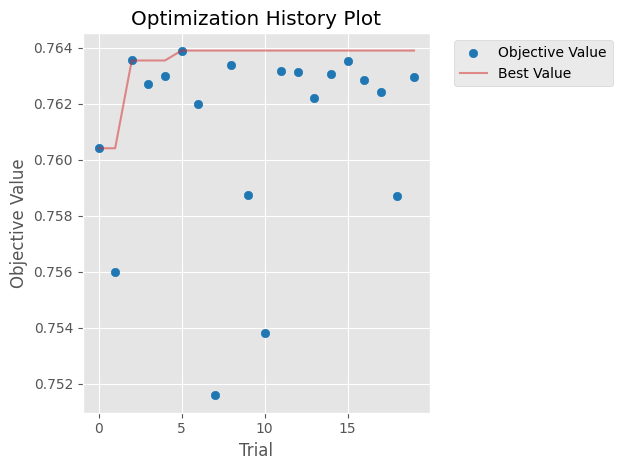

In [8]:
# 실행 및 시각화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print(f"\n✨ Best Score: {study.best_value:.4f}")

# Optuna 결과 시각화
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.show()

In [15]:
# 최적의 하이퍼파라미터 추출
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}\n")

# 전체 train 데이터를 8:2로 나눠서 학습 중 성능을 모니터링.
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    train_x, train_y, test_size=0.2, random_state=SEED, stratify=train_y
)

# Tensor 변환 및 MPS 장치 할당
X_train_t = torch.tensor(X_train_final, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train_final, dtype=torch.float32).view(-1, 1).to(DEVICE)
X_val_t = torch.tensor(X_val_final, dtype=torch.float32).to(DEVICE)
y_val_t = y_val_final # AUC 계산을 위해 원본(NumPy) 유지

# DataLoader 설정
batch_size = best_params.get('batch_size', 1024)
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

# 모델 및 히스토리 설정
final_model = nn.Sequential(
    nn.Linear(train_x.shape[1], best_params['hidden_dim']),
    nn.LeakyReLU(0.05),
    nn.Dropout(best_params['dropout']),
    nn.Linear(best_params['hidden_dim'], 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(DEVICE)

optimizer = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss()

# 최종 학습 실행
FINAL_EPOCHS = 25
history = {'train_loss': [], 'val_auc': []}

# 학습 및 실시간 검증 루프
pbar = tqdm(range(FINAL_EPOCHS), desc="Final Retraining")

for epoch in pbar:
    # 학습 모드
    final_model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = final_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    history['train_loss'].append(avg_loss)
    
    # 검증 모드
    final_model.eval()
    with torch.no_grad():
        val_logits = final_model(X_val_t).squeeze()
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
        current_val_auc = roc_auc_score(y_val_t, val_probs)
        history['val_auc'].append(current_val_auc)
    
    # tqdm 바 오른쪽에 정보 업데이트
    pbar.set_postfix({'Loss': f'{avg_loss:.4f}', 'Val_AUC': f'{current_val_auc:.4f}'})

Best Hyperparameters: {'lr': 0.0003118431735272311, 'hidden_dim': 225, 'dropout': 0.3063543592164552}



Final Retraining:   0%|          | 0/25 [00:00<?, ?it/s]

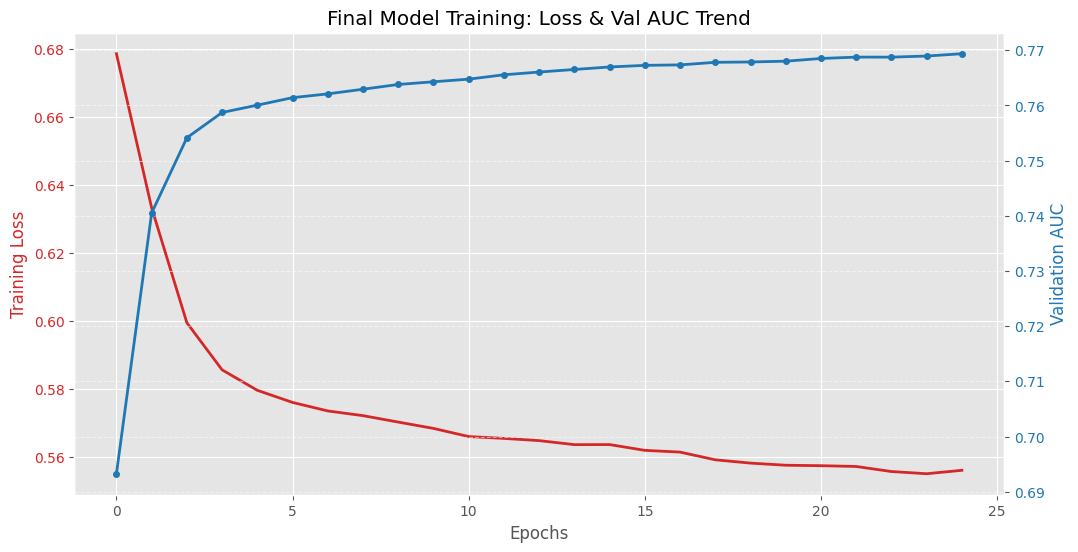

In [16]:
# 시각화 코드 추가 (이중 축 그래프)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='tab:red')
ax1.plot(history['train_loss'], color='tab:red', label='Train Loss', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation AUC', color='tab:blue')
ax2.plot(history['val_auc'], color='tab:blue', label='Val AUC', linewidth=2, marker='o', markersize=4)
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.title('Final Model Training: Loss & Val AUC Trend')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [17]:
# 최종 예측 (Inference)
final_model.eval()
with torch.no_grad():
    logits = final_model(X_test_t).squeeze()
    # BCEWithLogitsLoss를 썼으므로 Sigmoid를 통과시켜 확률값 생성
    final_probs = torch.sigmoid(logits).cpu().numpy()

# 제출 파일 저장
sample_sub = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
sample_sub["voted"] = final_probs

file_name = f"sub_optuna_v1_auc_{study.best_value:.4f}.csv"
save_path = os.path.join(SUB_PATH, file_name)

sample_sub.to_csv(save_path, index=False)

print(f"\nFinal Submission Saved: {save_path}")


Final Submission Saved: ./submissions/sub_optuna_v1_auc_0.7639.csv
